In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from keras.preprocessing.image import ImageDataGenerator # Library for data augmentation
from keras import backend, models, layers, optimizers
from keras.layers import Dense, Flatten

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import scipy

from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from keras.callbacks import EarlyStopping

In [3]:
# Construct the path to each desired file
base_path = "input/"

train_dir = base_path + "train/"
valid_dir = base_path + "valid/"
test_dir = base_path + "test/"

# Data will flow through this generator and will normalize
#train_datagen = ImageDataGenerator(rescale=1./255) Included later for the purpose of data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
from tensorflow.keras.applications import ResNet50V2

In [5]:
resnet_base = ResNet50V2(weights = 'imagenet',
                        include_top = False,
                        input_shape = (224, 224, 3))

In [16]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=40,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    fill_mode='nearest')

In [17]:
# Moves data from their respective directories to the model
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

valid_gen = train_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

Found 45980 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.
Found 1575 images belonging to 315 classes.


In [18]:
resnet_base.trainable = True

# Setting trainable layers within transfer learning base model
for layer in resnet_base.layers[:-5]:
  layer.trainable = False
for layer in resnet_base.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f22c461c910> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f22401ca520> False
<keras.layers.convolutional.Conv2D object at 0x7f22401ca8e0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f22401ca8b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f223f93abb0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223f8f5130> False
<keras.layers.core.activation.Activation object at 0x7f223c689250> False
<keras.layers.convolutional.Conv2D object at 0x7f223c6bb940> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223c689ca0> False
<keras.layers.core.activation.Activation object at 0x7f223c6bb9d0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f223c6a5c70> False
<keras.layers.convolutional.Conv2D object at 0x7f223c650a60> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f223c650b20> Fals

In [24]:
backend.clear_session()

# Model Creation
inputs = Input(shape=(224,224,3))
resnet_conv = resnet_base(inputs)
flatten_1 = layers.Flatten()(resnet_conv)
drop_1 = Dropout(0.5)(flatten_1)
dense_1 = layers.Dense(1024, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(drop_1)
batch_1 = BatchNormalization()(dense_1)
dense_2 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(batch_1)
outputs = layers.Dense(315, activation='softmax')(dense_2)

In [25]:
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    min_delta=0.001, 
    mode='max'
)

In [26]:
model_resnet = Model(inputs=inputs, outputs=outputs)

model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history = model_resnet.fit(train_gen,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_gen,
                       validation_steps = 50,
                       callbacks=[custom_early_stopping])

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

Epoch 1/100
100/100 [==============================] - 130s 1s/step - loss: 7.4305 - accuracy: 0.1005 - val_loss: 5.9649 - val_accuracy: 0.2740
Epoch 2/100
100/100 [==============================] - 128s 1s/step - loss: 5.8342 - accuracy: 0.3145 - val_loss: 4.6443 - val_accuracy: 0.4480
Epoch 3/100
100/100 [==============================] - 135s 1s/step - loss: 4.9529 - accuracy: 0.4510 - val_loss: 3.9486 - val_accuracy: 0.6200
Epoch 4/100
100/100 [==============================] - 139s 1s/step - loss: 4.4080 - accuracy: 0.5480 - val_loss: 3.4949 - val_accuracy: 0.6950
Epoch 5/100
100/100 [==============================] - 134s 1s/step - loss: 3.9985 - accuracy: 0.6145 - val_loss: 3.2907 - val_accuracy: 0.7260
Epoch 6/100
100/100 [==============================] - 152s 2s/step - loss: 3.6924 - accuracy: 0.6795 - val_loss: 3.0852 - val_accuracy: 0.7740
Epoch 7/100
100/100 [==============================] - 139s 1s/step - loss: 3.4962 - accuracy: 0.7140 - val_loss: 2.9506 - val_accuracy:

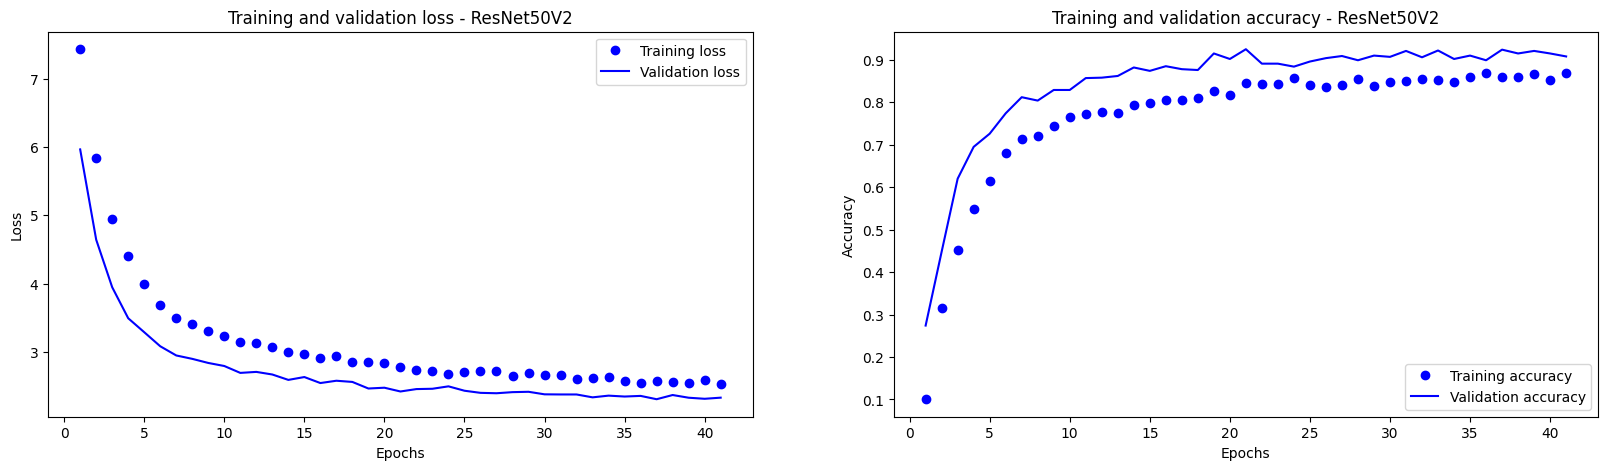

In [27]:
# Plotting Training accuracy vs Validation accuracy for comparison
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50V2')
plt.xlabel('Epochs')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [28]:
resnet_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [29]:
test_loss, test_accuracy = model_resnet.evaluate(test_gen)
print('Test Accuracy: ' + str(test_accuracy))

79/79 [==============================] - 36s 458ms/step - loss: 2.2296 - accuracy: 0.9422
Test Accuracy: 0.9422222375869751


In [15]:
pred = model_resnet.predict(test_gen)
actual = os.join

import sklearn
from sklearn.metrics import confusion_matrix

print(len(pred))

AttributeError: module 'os' has no attribute 'join'

In [ ]:
# Data Augmentation
train_datagen2 = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=40,
    fill_mode='nearest')

In [ ]:
# Moves data from their respective directories to the model
train_gen2 = train_datagen2.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

valid_gen2 = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

In [ ]:
resnet_base2.trainable = True

# Setting trainable layers within transfer learning base model
for layer in resnet_base2.layers[:-6]:
  layer.trainable = False
for layer in resnet_base2.layers:
  print(layer, layer.trainable)

In [ ]:
# Model Creation
inputs = Input(shape=(224,224,3))
resnet_conv = resnet_base2(inputs)
flatten_1 = layers.Flatten()(resnet_conv)
drop_1 = Dropout(0.2)(flatten_1)
dense_1 = layers.Dense(1024, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(drop_1)
batch_1 = BatchNormalization()(dense_1)
dense_2 = layers.Dense(512, activation = 'relu', kernel_regularizer = regularizers.L2(0.001))(batch_1)
outputs = layers.Dense(315, activation='softmax')(dense_2)

In [ ]:
custom_early_stopping2 = EarlyStopping(
    monitor='val_accuracy', 
    patience=20, 
    min_delta=0.001, 
    mode='max'
)

In [ ]:
model_resnet2 = Model(inputs=inputs, outputs=outputs)

model_resnet2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

history2 = model_resnet2.fit(train_gen,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_gen,
                       validation_steps = 50,
                       callbacks=[custom_early_stopping2])

history_dict2 = history.history2
loss_values2 = history_dict2['loss']
val_loss_values2 = history_dict2['val_loss']
acc_values2 = history_dict2['accuracy']
val_acc_values2 = history_dict2['val_accuracy']
epochs2 = range(1, len(history_dict2['accuracy']) + 1)

In [ ]:
# Plotting Training accuracy vs Validation accuracy for comparison
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(epochs2, loss_values2, 'bo', label = 'Training loss')
plt.plot(epochs2, val_loss_values2, 'b', label = 'Validation loss')
plt.title('Training and validation loss - ResNet50V2')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs2, acc_values2, 'bo', label = 'Training accuracy')
plt.plot(epochs2, val_acc_values2, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy - ResNet50V2')
plt.xlabel('Epochs')
plt.yticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
test_loss2, test_accuracy2 = model_resnet2.evaluate(test_gen)
print('Test Accuracy: ' + str(test_accuracy2))

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip = True,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest')

In [ ]:
# Moves data from their respective directories to the model
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

valid_gen = test_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=20,
    class_mode="categorical")

In [ ]:
resnet_base.trainable = True

# Setting trainable layers within transfer learning base model
for layer in resnet_base.layers[:-5]:
  layer.trainable = False
for layer in resnet_base.layers:
  print(layer, layer.trainable)